# Hybrid model: linear reservoir
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 25-09-2024<br>

* [x] Check the values of residence time ($T$) generated by the LSTM+dense layers.
* [x] Check if the model weights are equal across epochs, which would indicate that the model is not learning. <font color='blue'>They are the same indeed, so the model is not learning.</font>. **FIXED** There were two issues in `LinearReservoir.forward()`:
    * `torch.clamp()` does not do the same as `torch.min(torch.max())`
    * `eps = torch.tensor(..., requires_grad=True, ...)` 
* [ ] Check if the gradients are too small. The inflow/outflow values are very, very small, which could cause small gradients.
* [ ] ¿What's the effect of the <font color='blue'>**warmup period**</font>? Should it be only one day less than the sequence length?
* [ ] Test the best initial value for the initial fraction filled.
* [ ] Try the manual run with several basins in the test sample.
* [ ] Train on storage instead of outflow. Storage needs to be the only variable in `out` (`LinearReservoir.forward()`)
* [ ] Train on both storage and outflow. Storage needs to be added as the second variable in `out` (`LinearReservoir.forward()`)
* [ ] To clip or not to clip gradients?

The fitted residence time varies a lot (probably too much) with time!! Reduce the influence of dynamic inputs? Add static inputs that define the hydroclimatic charateristics of the basin.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf

from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo import get_model
# from neuralhydrology.training import get_optimizer, get_loss_obj, get_regularization_obj
# from neuralhydrology.training.basetrainer import BaseTrainer
# from neuralhydrology.nh_run import start_run
# from neuralhydrology.training.train import start_training
# from neuralhydrology.evaluation.evaluate import start_evaluation
# from neuralhydrology.evaluation import get_tester
from neuralhydrology.evaluation.plots import boxplot_performance, map_performance, boxplot_parameters, lineplot_timeseries

## Configuration

In [3]:
MODEL_PATH = Path('/eos/jeodpp/home/users/casadje/models/ResOpsUS/hybrid_model/')

run_dir = MODEL_PATH / 'linear_reservoir' / 'storage' / 'benchmark_2309_154018'

# read configuration file
cfg = Config(run_dir / 'config.yml')

# # get the optimizer
# optimizer = get_optimizer(model, cfg)
# print(optimizer)

# # get the loss object
# loss_obj = get_loss_obj(cfg)
# loss_obj.set_regularization_terms(get_regularization_obj(cfg))
# print(loss_obj)

## Data

### Attributes

In [4]:
# load list of reservoirs
reservoirs = sorted(pd.read_csv(cfg.test_basin_file, header=None)[0].tolist())

# load attributes
attributes = pd.concat([pd.read_csv(file, index_col='GRAND_ID') for file in (cfg.data_dir / 'attributes').glob('*.csv')], 
                       axis=1,
                       join='outer')
attributes.index.name = 'id'
attributes = attributes.loc[reservoirs, cfg.static_attributes]

print('no. reservoirs in the attribute tables:', attributes.shape[0])

no. reservoirs in the attribute tables: 118


### Time series

In [5]:
# load time series
dynamic_vars = cfg.dynamic_inputs + cfg.dynamic_conceptual_inputs + cfg.target_variables 
if 'storage_norm' not in cfg.target_variables:
    dynamic_vars += ['storage_norm']
if 'outflow_norm' not in cfg.target_variables:
    dynamic_vars += ['outflow_norm']
timeseries = {ID: xr.open_dataset(cfg.data_dir / 'time_series' / f'{ID}.nc').to_pandas()[dynamic_vars] for ID in reservoirs}
# trim time series to the test period
with open(cfg.per_basin_test_periods_file, 'rb') as file:
    periods = pickle.load(file)
periods = {ID: dct for ID, dct in periods.items() if int(ID) in reservoirs}
for ID, ts in timeseries.items():
    start, end = [periods[str(ID)][x][0] for x in ['start_dates', 'end_dates']]
    ts = ts.loc[start:end]

# # plot time series
# for ID, ts in timeseries.items():
#     start, end = [ls[0] for key, ls in periods[str(ID)].items()]
#     fig, ax = plt.subplots(nrows=2, figsize=(15, 6), sharex=True)
#     ts.loc[start:end, ['inflow_norm', 'outflow_norm']].plot(ax=ax[0], lw=.8);
#     ts.loc[start:end, ['storage_norm']].plot(ax=ax[1], lw=.8)
#     ax[0].set_title(ID)
#     ax[1].set(ylim=(-.02, 1.02),
#               ylabel='storage (-)',
#               );
#     plt.savefig(cfg.data_dir / 'plots' / f'{ID:04}.jpg')

## Analyse results

### Performance

In [6]:
metric = cfg.metrics[0]

# performance of each reservoir, sample and epoch
performance = {sample: [] for sample in ['train', 'validation']}#, 'test']}
for sample, perf_list in performance.items():
    for epoch in range(1, cfg.epochs + 1):
        try:
            aux = pd.read_csv(run_dir / sample / f'model_epoch{epoch:03}' / f'{sample}_metrics.csv',
                              index_col='basin').squeeze()
            aux.name = epoch
            perf_list.append(aux)
        except Exception as e:
            print(e)
performance = {sample: pd.concat(perf_list, axis=1) for sample, perf_list in performance.items()}

# best epoch
best_epoch = performance['validation'].median(axis=0).idxmax()
print(f'best epoch:\t{best_epoch}')
for sample, df in performance.items():
    print('{0} {1}:\t{2:.3f}'.format(metric, sample, df[best_epoch].median()))

best epoch:	5
KGE train:	0.845
KGE validation:	0.242


In [24]:
# define sample and performance of each reservoir
for sample, df in performance.items():
    attributes.loc[df.index, 'sample'] = sample
    attributes.loc[df.index, metric] = df[best_epoch]

In [ ]:
# add performance to the attributes
cols = [f'{metric}_{sample}' for sample in performance.keys()]
if len(attributes.columns.intersection(cols)) == 0:
    attributes = pd.concat((attributes, pd.DataFrame({f'{metric}_{sample}': df[best_epoch] for sample, df in performance.items()})), axis=1)

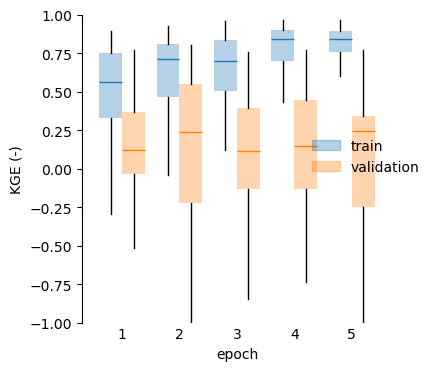

In [25]:
# boxplot performance
boxplot_performance(cfg, performance, save=run_dir / 'performance_boxplot.jpg')

In [45]:
from typing import Optional, Union
def map_performance(
    x: pd.Series,
    y: pd.Series,
    color: pd.Series,
    samples: pd.Series,
    save: Optional[Union[str, Path]] = None,
    **kwargs
):
    """
    Plot a map showing the performance of different samples based on a specified metric.

    This function creates a scatter plot on a map with points representing the performance 
    metric values at their respective latitude and longitude coordinates. The points are 
    color-coded based on the metric value and use different markers for each sample.

    Parameters:
    -----------
    attributes (pd.DataFrame): A DataFrame containing the latitude ('LAT') and longitude 
        ('LON') columns along with columns for each performance metric. Performance metric
        columns must be prefixed with the metric name (e.g., 'KGE_sample1', 'KGE_sample2').
    metric (str, optional): The name of the performance metric to be visualized. Metric 
        column names in `attributes` should start with this name. Defaults to 'KGE'.
    save (Optional[Union[str, Path]], optional): The file path or name where the plot
        should be saved. If None, the plot will not be saved. Defaults to None.
    **kwargs: Arbitrary keyword arguments. Recognized arguments:
        - figsize (tuple): The figure size in inches (width, height). Defaults to (12, 4).
        - cmap (str): The colormap name used to color the points. Defaults to 'coolwarm_r'.

    Returns:
    --------
        None
    """
    
    clim = kwargs.get('clim', (-1 , 1))
    figsize = kwargs.get('figsize', (12, 4))
    cmap = kwargs.get('cmap', 'coolwarm_r')

    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
    ax.axis('off')

    markers = ['o', '^', 'x']
    legend_handles = []
    for sample, marker in zip(samples.unique(), markers):
        mask = attributes['sample'] == sample
        sct = ax.scatter(x[mask], y[mask], c=color[mask], marker=marker, vmin=clim[0], vmax=clim[1], cmap=cmap, label=sample)
        legend_handle = mlines.Line2D([], [], color='gray', marker=marker, linestyle='None',
                                      markersize=6, label=sample)
        legend_handles.append(legend_handle)

    ax.legend(handles=legend_handles, frameon=False)
    fig.colorbar(sct, shrink=.666, label=color.name);
    
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

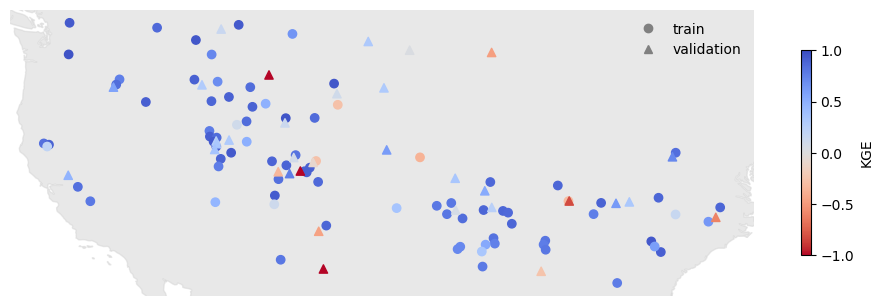

In [48]:
# map performance
map_performance(attributes.LON, attributes.LAT, attributes[metric], attributes['sample'], save=run_dir / f'performance_map_epoch{best_epoch:03}')

In [ ]:
# # compare reservoir performance in the best epoch between the train and validation sets
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.plot([-2, 2], [-2, 2], c='k', lw=.5, zorder=0)
# for sample, df in performance.items():
#     try:
#         ax.scatter(df[1], df[best_epoch], alpha=.5, label=sample)
#     except:
#         continue
# ax.legend(frameon=False, loc=4)
# ax.set(xlim=(-1.02, 1.02),
#        ylim=(-1.02, 1.02),
#        xlabel='epoch 1',
#        ylabel=f'epoch {best_epoch}',
#        title='KGE (-)');

### Analyse weights and biases

In [50]:
# get the hybrid model: LSTM + LinearReservoir
model = get_model(cfg).to(cfg.device)
print(model)
print('device:', next(model.parameters()).device)

# load model states
weights = {}
for epoch in range(1, cfg.epochs + 1):
    try:
        weights[epoch] = torch.load(run_dir / f'model_epoch{epoch:03}.pt',)
    except:
        break

# check if weights are the same in the first and last epoch
par = 'lstm.bias_ih_l0' #'lstm.weight_ih_l0' # 'lstm.weight_hh_l0'
for par in weights[1].keys():
    if torch.allclose(weights[1][par], weights[5][par]): # cfg.epochs][par]):
        print(f'{par:<17} is the same in the first and last epoch')

# load model states from the last epoch
model.load_state_dict(weights[best_epoch])

HybridModel(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(28, 256)
  (conceptual_model): LinearReservoirV()
  (linear): Linear(in_features=256, out_features=1, bias=True)
)
device: cuda:0


<All keys matched successfully>

#### LSTM

```Python
for name, param in model.lstm.named_parameters():
    print(f'Parameter name: {name}', end='\t')
    print(f'shape: {param.size()}', end='\t')
    print(f'device: {param.device}', end='\t')
    print(f'requires_grad: {param.requires_grad}')
    if len(param.shape) == 1:
        plt.figure()
        plt.plot(param.detach().cpu().numpy())
        plt.title(name)
    elif len(param.shape) == 2:
        plt.figure()
        plt.imshow(param.detach().cpu().numpy())
        plt.title(name)
```

#### Linear

```Python
for name, param in model.linear.named_parameters():
    print(f'Parameter name: {name}', end='\t')
    print(f'shape: {param.size()}', end='\t')
    print(f'device: {param.device}', end='\t')
    print(f'requires_grad: {param.requires_grad}')
    if len(param.shape) == 1:
        print(f'bias = {param[0]:.3f}')
        # plt.figure()
        # plt.plot(param.detach().cpu().numpy())
        # plt.title(name)
    elif len(param.shape) == 2:
        plt.figure()
        plt.imshow(param.detach().cpu().numpy())
        plt.title(name)
```

## Results

### `<sample>_results.p`

In [ ]:
# results = {}
# for sample in ['train', 'validation', 'test']:
#     with open(run_dir / sample / f'model_epoch{best_epoch:03}' / f'{sample}_results.p', 'rb') as file:
#         results[sample] = pickle.load(file)

### `<sample>_all_output.p`

In [ ]:
# all_output = {}
# for sample in ['train', 'validation', 'test']:
#     try:
#         with open(run_dir / sample / f'model_epoch{best_epoch:03}' / f'{sample}_all_output.p', 'rb') as file:
#             all_output[sample] = pickle.load(file)
#     except Exception as e:
#         print(e)
#         continue

In [ ]:
# all_output['train']['1020'].keys()

It contains only the tensor put out by the hybrid model (`[days, seq_length - warmup, target]`)

### `<sample>_metrics.csv`

## Evaluation

In [ ]:
sample = 'validation' # 'test'

# load test data
scaler = load_scaler(run_dir)
dataset = get_dataset(cfg,
                      is_train=False,
                      period=sample,
                      scaler=scaler)
dataloader = DataLoader(dataset,
                        batch_size=1000,
                        shuffle=False,
                        collate_fn=dataset.collate_fn)

print(f'no. basins in the {sample} sample: {len(dataset.basins)}')

### "Manually"

In [ ]:
# # set model in evaluation mode
# model.eval()

# save_all_output = True
# frequencies = dataset.frequencies
# predict_last_n = cfg.predict_last_n
# if isinstance(predict_last_n, int):
#     predict_last_n = {frequencies[0]: predict_last_n}

# from typing import Dict

# def _subset_targets(
#     # model: BaseModel,
#     data: Dict[str, torch.Tensor],
#     predictions: np.ndarray,
#     predict_last_n: np.ndarray,
#     freq: str
# ):
#     """Subset the last n values in both observed and predicted target variables"""
#     y_hat_sub = predictions[f'y_hat{freq}'][:, -predict_last_n:, :]
#     y_sub = data[f'y{freq}'][:, -predict_last_n:, :]
    
#     return y_hat_sub, y_sub

# preds, obs, dates, all_output = {}, {}, {}, {}
# losses = []

# with torch.no_grad():
#     for data in dataloader:
#         for key in data:
#             if not key.startswith('date'):
#                 data[key] = data[key].to(cfg.device)
#         data = model.pre_model_hook(data, is_train=False)
#         # predict
#         predictions = model(data)
#         # compute loss
#         _, loss = loss_obj(predictions, data)
#         loss = {k: v.item() for k, v in loss.items()}
        
#         if all_output:
#             for key, value in predictions.items():
#                 if value is not None and type(value) != dict:
#                     all_output[key].append(value.detach().cpu().numpy())
#         elif save_all_output:
#             all_output = {
#                 key: [value.detach().cpu().numpy()]
#                 for key, value in predictions.items()
#                 if value is not None and type(value) != dict
#             }
                
#         for freq in frequencies:
#             if predict_last_n[freq] == 0:
#                 continue  # no predictions for this frequency
#             freq_key = '' if len(frequencies) == 1 else f'_{freq}'
#             y_hat_sub, y_sub = _subset_targets(data,
#                                                predictions,
#                                                predict_last_n[freq],
#                                                freq_key)
#             # Date subsetting is universal across all models and thus happens here.
#             date_sub = data[f'date{freq_key}'][:, -predict_last_n[freq]:]
            
#             # save results
#             if freq not in preds:
#                 preds[freq] = y_hat_sub.detach().cpu()
#                 obs[freq] = y_sub.cpu()
#                 dates[freq] = date_sub
#             else:
#                 preds[freq] = torch.cat((preds[freq], y_hat_sub.detach().cpu()), 0)
#                 obs[freq] = torch.cat((obs[freq], y_sub.detach().cpu()), 0)
#                 dates[freq] = np.concatenate((dates[freq], date_sub), axis=0)
                
#         losses.append(loss)
        
#     for freq in preds.keys():
#         preds[freq] = preds[freq].numpy()
#         obs[freq] = obs[freq].numpy()

# # concatenate all output variables (currently a dict-of-dicts) into a single-level dict
# for key, list_of_data in all_output.items():
#     all_output[key] = np.concatenate(list_of_data, 0)
    
# # set to NaN explicitly if all losses are NaN to avoid RuntimeWarning
# mean_losses = {}
# if len(losses) == 0:
#     mean_losses['loss'] = np.nan
# else:
#     for loss_name in losses[0].keys():
#         loss_values = [loss[loss_name] for loss in losses]
#         mean_losses[loss_name] = np.nanmean(loss_values) if not np.all(np.isnan(loss_values)) else np.nan

### Basin per basin

In [ ]:
def evaluate(cfg, model, dataloader):
    """It runs the hybrid model step by step for a single basin and puts out the input of the conceptual model, the model parameters, internal states and target variable
    
    Taken from `HybridModel.forward()`
    """
    
    model.eval()
    predictions = []
    inflow = []
    # obs = []
    with torch.no_grad():
        for data in dataloader:

            # run the LSTM
            # concatenate dynamic and static variables
            x_s_expanded = data['x_s'].unsqueeze(1).expand(-1, data['x_d'].size(1), -1)
            x_concatenated = torch.cat((data['x_d'], x_s_expanded), dim=2).to(cfg.device)
            lstm_output, _ = model.lstm(x_concatenated)

            # run the FC
            linear_output = model.linear(lstm_output[:, cfg.warmup_period:, :])

            # run conceptual model
            x_conceptual = data['x_d_c'][:, cfg.warmup_period:, :]
            pred = model.conceptual_model(x_conceptual=x_conceptual.to(cfg.device),
                                          lstm_out=linear_output)
            inflow.append(x_conceptual)
            predictions.append(pred)
    
    pred = {
        'inflow': torch.cat(inflow, dim=0),
        'storage': torch.cat([pred['internal_states']['ff'] for pred in predictions], dim=0).detach().cpu(),
        'parameters': torch.cat([pred['parameters']['T'] for pred in predictions], dim=0).detach().cpu()
    }
    if cfg.target_variables[0].split('_')[0] == 'outflow':
        pred['outflow'] = torch.cat([pred['y_hat'] for pred in predictions], dim=0).detach().cpu()
    
    return pred

In [ ]:
# load model states from the last epoch
model.load_state_dict(weights[best_epoch])

# load scaler
scaler = load_scaler(run_dir)

attributes['samples'] = ''
results = {sample: {} for sample in ['train', 'validation']}
for sample, results_sample in results.items():
    # load sample data
    dataset = get_dataset(cfg,
                          is_train=False,
                          period=sample,
                          scaler=scaler)
    basins = [int(basin) for basin in dataset.basins]
    attributes.loc[basins, 'sample'] = sample

    # run evaluation basin per basin
    pbar = tqdm(dataset.basins, desc=f'# {sample}')
    for basin in pbar:
        # load dataset
        ds = get_dataset(cfg=cfg,
                         is_train=False,
                         period=sample,
                         basin=basin,
                         # additional_features=self.additional_features,
                         # id_to_int=self.id_to_int,
                         scaler=scaler)

        # setup data loader
        loader = DataLoader(ds,
                            batch_size=cfg.batch_size,
                            num_workers=0,
                            collate_fn=ds.collate_fn)
        
        # evaluate
        results_sample[basin] = evaluate(cfg, model, loader)

In [ ]:
# convert results to pandas.DataFrame
results_df = {sample: {} for sample in results}
for sample, results_sample in results.items():
    for basin, dct in results_sample.items():
        # define date index
        start, end = [periods[basin][f'{x}_dates'][0] for x in ['start', 'end']]
        dates = pd.date_range(start, end, freq='1D')
        
        # concatenate time series
        results_df[sample][basin] = pd.concat((
            pd.Series(dct['inflow'].numpy()[:, -1, 0], index=dates, name='inflow'),
            pd.Series(dct['parameters'].numpy()[:, -1], index=dates, name='T'),
            pd.Series(dct['storage'].numpy()[:, -1], index=dates, name='storage'),
            # pd.Series(results[basin]['outflow'].numpy()[:, -1, 0], index=dates, name='outflow'),
        ),
            axis=1
        )
        if 'outflow' in dct:
            results_df[sample][basin] = pd.concat((
                results_df[sample][basin],
                pd.Series(dct['outflow'].numpy()[:, -1, 0], index=dates, name='outflow'),
            ),
            axis=1
        )

In [ ]:
# sample = 'validation' # 'test'

# # load test data
# dataset = get_dataset(cfg,
#                       is_train=False,
#                       period=sample,
#                       scaler=scaler)
# # dataloader = DataLoader(dataset,
# #                         batch_size=1000,
# #                         shuffle=False,
# #                         collate_fn=dataset.collate_fn)

# print(f'no. basins in the {sample} sample: {len(dataset.basins)}')

In [ ]:
# # load model states from the last epoch
# model.load_state_dict(weights[1])

# # run evaluation basin per basin
# pbar = tqdm(dataset.basins)
# pbar.set_description('# Validation' if sample == "validation" else "# Evaluation")
# results = {}
# for basin in pbar:
#     # load dataset
#     ds = get_dataset(cfg=cfg,
#                      is_train=False,
#                      period=sample,
#                      basin=basin,
#                      # additional_features=self.additional_features,
#                      # id_to_int=self.id_to_int,
#                      scaler=scaler)
    
#     # setup data loader
#     loader = DataLoader(ds,
#                         batch_size=cfg.batch_size,
#                         num_workers=0,
#                         collate_fn=ds.collate_fn)

#     results[basin] = evaluate(cfg, model, loader)

### Analyse results

#### Parameters

In [ ]:
# concatenate the median fitted parameter to the attributes table
# if 'T' in attributes.columns:
#     attributes.drop('T', axis=1, inplace=True)
attributes['T'] = pd.Series({int(basin): df['T'].median(skipna=True) for sample, dct in results_df.items() for basin, df in dct.items()}, name='T')
# fitted_par.index.name = 'id'
# attributes = pd.concat((attributes, fitted_par), axis=1)

In [ ]:
# export median value
PATH_OUT = run_dir / sample / f'model_epoch{best_epoch:03}' 
attributes[['T']].to_csv(PATH_OUT / f'{sample}_parameters.csv')

# map fitted parameter
path_plots = PATH_OUT / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(12, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
ax.axis('off')
vmin, vmax = model.conceptual_model.parameter_ranges['T']
markers = ['o', '^', 'x']
legend_handles = []
for sample, marker in zip(attributes['sample'].unique(), markers):
    mask = attributes['sample'] == sample
    sct = ax.scatter(attributes[mask].LON, attributes[mask].LAT, c=attributes[mask]['T'], marker=marker, vmin=vmin, vmax=vmax, cmap='viridis')
    legend_handle = mlines.Line2D([], [], color='gray', marker=marker, linestyle='None',
                                      markersize=6, label=sample)
    legend_handles.append(legend_handle)
    
ax.legend(handles=legend_handles, frameon=False)
fig.colorbar(sct, shrink=.666, label='T (days)');

plt.savefig(run_dir / f'parameter_map_epoch{best_epoch:03}.jpg')

#### Time series

In [ ]:
# plot simulated vs observed timeseries
# dynamic_inputs = list(set(cfg.dynamic_inputs).difference(['dow_sin', 'dow_cos']))
for sample, dct in results_df.items():
    path_out = run_dir / sample / f'model_epoch{best_epoch:03}' / 'plots'
    path_out.mkdir(parents=True, exist_ok=True)
    for ID, df in dct.items():
        lineplot_timeseries(
            cfg,
            sim=df,
            obs=timeseries[int(ID)],
            xlim=[periods[str(ID)][f'{dt}_dates'][0] for dt in ['start', 'end']],
            ylim=model.conceptual_model.parameter_ranges['T'],
            title=ID,
            save=path_plots / f'{ID}.jpg'
        )

In [ ]:
# boxplot of simulated parameters
for sample, dct in results_df.items():
    path_out = run_dir / sample / f'model_epoch{best_epoch:03}' / 'plots'
    path_out.mkdir(parents=True, exist_ok=True)
    boxplot_parameters(
        dct,
        'T',
        attributes['DOR_PC'] * 3.65,
        ylabel='T (days)',
        ylim=(vmin, vmax),
        save=path_out / 'parameters_boxplot.jpg'
    )

***

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)

ax[0].scatter(attributes[f'KGE_{sample}'], attributes['T'], s=5, alpha=.5, c=attributes.CAP_MCM)
ax[0].set(ylabel='residence time (days)',
          ylim=(vmin * .98, vmax * 1.02),
          xlabel='KGE (-)',
          xlim=(None, 1.02));

sct = ax[1].scatter(attributes['T'], attributes['DOR_PC'] * 3.65, s=5, alpha=.5, c=attributes.CAP_MCM)
ax[1].set(
    xlabel='DOR (days)'
);

In [ ]:
# fig.colorbar(sct, shrink=.67, label='capacity (MCM)')

for i, (basin, df) in enumerate(results_df.items()):
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['T'], lw=.8)
    ax.axhline(attributes.loc[int(basin), 'T'], c='k', ls='--', lw=.8)
    ax.axhline(attributes.loc[int(basin), 'DOR'] * 365, c='k', ls=':', lw=.8)
    ax.set(
        ylim=(7, 2190),
        title=basin
    )
    if i == 19:
        break

***

In [ ]:
ID = performance[sample][best_epoch].idxmax()
# ID = 300 #445 # 372 # 1032

ID, performance[sample][best_epoch].max()

#### Parameters

In [ ]:
par = results[str(ID)]['parameters'].numpy()
print(par.shape)

vmin, vmax = model.conceptual_model.parameter_ranges['T']
fig, ax = plt.subplots()#figsize=(15, 3))
im = ax.imshow(np.transpose(par), vmin=vmin, vmax=vmax)
ax.set(
    xlabel='date',
    ylabel='warmup (d)'
)
# ax.set_xticklabels([dt.date() for dt in dates[::1000]])
fig.colorbar(im, shrink=.333, label='parameter T (d)', orientation='horizontal');#, pad=.35);

#### Outflow

In [ ]:
if 'outflow' in results[str(ID)]:
    out = results[str(ID)]['outflow'].numpy()[:,:,0]
    print(out.shape)

    im = plt.imshow(np.transpose(out), vmin=0)
    plt.colorbar(im, shrink=.333, label='outflow (-)', orientation='horizontal');

#### Storage

In [ ]:
state = results[str(ID)]['storage'].numpy()
print(state.shape)
im = plt.imshow(np.transpose(state), vmin=0, vmax=1)
plt.colorbar(im, shrink=.333, label='storage (-)', orientation='horizontal');

Evolution of parameter $T$, outflow and storage over the simulation period for different steps in the warmup period.

In [ ]:
dates = pd.date_range(*[periods[str(ID)][f'{dt}_dates'][0] for dt in ['start', 'end']])

fig, ax = plt.subplots(nrows=3, figsize=(15, 6), sharex=True)
lw = .3
for n, i in enumerate(np.linspace(0, state.shape[1] - 1, 3)):
    # c = 'k' if i == out.shape[1] - 1 else f'C{n}'
    c = f'C{abs(2 - n)}'
    if 'outflow_norm' in cfg.target_variables:
        ax[0].plot(pd.Series(out[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')
    ax[1].plot(pd.Series(state[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')
    ax[2].plot(pd.Series(par[:, int(i)], index=dates), c=c, lw=lw*(n+1), label=f'warmup={i:.0f}')

# observed
ax[0].plot(timeseries[int(ID)].loc[dates, 'outflow_norm'], lw=lw*(n+1), c='k', zorder=0, label='obs')
ax[1].plot(timeseries[int(ID)].loc[dates, 'storage_norm'], lw=lw*(n+1), c='k', zorder=0, label='obs')
    
ax[0].set(xlim=(dates[0], dates[-1]),
          ylim=(0, None),
          ylabel='outflow (-)')
ax[1].set(ylim=(-.05, 1.05),
          ylabel='storage (-)')
ax[2].set(ylim=model.conceptual_model.parameter_ranges['T'],
          ylabel='T (days)')
ax[-1].set_xlabel('date')

# ax[-1].set_xlim((pd.Timestamp(2000, 1, 1), pd.Timestamp(2001, 1, 1)))

fig.legend(*ax[1].get_legend_handles_labels(), frameon=False, loc=5, bbox_to_anchor=[.9, .33, .15, .33]);

Evolution of outflow, storage and parameter $T$ over the warmup period for several dates.

```Python
fig, ax = plt.subplots(nrows=3, figsize=(12, 6), sharex=True)
lw = .8
for n, i in enumerate(np.linspace(0, state.shape[0] - 1, 3)):
    # c = 'k' if i == state.shape[0] - 1 else f'C{n}'
    c = f'C{abs(2 - n)}'
    date = dates[int(i)]
    
    ax[0].plot(out[int(i), :], c=c, lw=lw, label=date.strftime('%Y-%m-%d'))
    ax[0].axhline(timeseries[ID].loc[date, 'outflow_norm'], c=c, ls='--', lw=lw)
    
    ax[1].plot(state[int(i), :], c=c, lw=lw)
    ax[1].axhline(timeseries[ID].loc[date, 'storage_norm'], c=c, ls='--', lw=lw)
    
    ax[2].plot(par[int(i), :], c=c, lw=lw)

ax[0].axhline(-10, c='gray', ls='--', lw=lw, label='obs')

ax[0].set(ylim=(0, None),
          ylabel='outflow (-)')
ax[1].set(ylim=(-.02, 1.02),
          ylabel='storage (-)')
ax[2].set(ylim=model.conceptual_model.parameter_ranges['T'],
          ylabel='T (days)')
ax[-1].set_xlabel('warmup');

fig.legend(*ax[0].get_legend_handles_labels(), frameon=False, loc=5);
```

***

### Using a `tester`

In [ ]:
tester = get_tester(cfg=cfg,
                    run_dir=run_dir,
                    period='train',
                    init_model=True)

In [ ]:
cfg.save_all_output

In [ ]:
output = tester.evaluate(epoch=best_epoch,
                         save_results=False,
                         save_all_output=True, #cfg.save_all_output,
                         metrics=cfg.metrics)

In [ ]:
output['1020']['1D']['xr']

In [ ]:
output['10']['1D']

In [ ]:
cfg.target_variables[0]

In [ ]:
output['1020']['1D']['xr']['storage_norm_obs'].plot()

output['1020']['1D']['xr']['storage_norm_sim'].plot()

In [ ]:
start_evaluation(cfg,
                 run_dir,
                 epoch=best_epoch,
                 period='train')

In [ ]:
cfg.test_basin_file

In [ ]:
tester.model

In [ ]:
tester.basins

In [ ]:
tester.basins

In [ ]:
tester.basins

In [ ]:
basin = tester.basins[0]
print('reservoir:', basin)

In [ ]:
model.eval()

In [ ]:
# fetch basin data
if tester.cfg.cache_validation_data and basin in tester.cached_datasets.keys():
    ds = self.cached_datasets[basin]
else:
    try:
        ds = tester._get_dataset(basin)
    except NoEvaluationDataError as error:
        print('skip basin:', basin)
    if tester.cfg.cache_validation_data and tester.period == "validation":
        tester.cached_datasets[basin] = ds

# setup data loader
loader = DataLoader(ds,
                    batch_size=tester.cfg.batch_size,
                    num_workers=0,
                    collate_fn=ds.collate_fn)

In [ ]:
with torch.no_grad():
    for data in loader:
        for key in data:
            if not key.startswith('date'):
                data[key] = data[key].to(cfg.device)
        data = model.pre_model_hook(data, is_train=False)
        break

In [ ]:
data['x_d'].shape, data['x_s'].shape, data['x_d_c'].shape, data['y'].shape

In [ ]:
        predictions = model(data)
        predictions['y_hat'].shape, predictions['parameters']['T'].shape, predictions['internal_states']['ff'].shape

In [ ]:
        _, all_losses = tester.loss_obj(predictions, data)
        all_losses = {k: v.item() for k, v in all_losses.items()}
        all_losses

In [ ]:
model.conceptual_model.parameter_ranges

In [ ]:
par = 'T'
par_range = model.conceptual_model.parameter_ranges[par]
im = plt.imshow(
    predictions['parameters'][par].detach().cpu(), 
    vmin=par_range[0],
    vmax=par_range[1]
)
plt.colorbar(im, shrink=.5, label='T (days)')
plt.xlabel('time step')
plt.ylabel('batch size');

In [ ]:
im = plt.imshow(
    predictions['internal_states']['ff'].detach().cpu(),
    vmin=0,
    vmax=1
)
plt.colorbar(im, shrink=.5, label='fraction filled (-)')
plt.xlabel('time step')
plt.ylabel('batch size');

In [ ]:
data['x_d_c'].min(), data['x_d_c'].max()

In [ ]:
im = plt.imshow(
    predictions['y_hat'][:,:,0].detach().cpu(),
)
plt.colorbar(im, shrink=.5, label='outflow (-)')
plt.xlabel('time step')
plt.ylabel('batch size');

In [ ]:
validation = tester.evaluate(epoch=best_epoch,
                             save_results=False,
                             save_all_output=False, #cfg.save_all_output,
                             metrics=cfg.metrics,
                             model=model)

In [ ]:
validation['110']['1D']['xr'].to_dataframe().plot(lw=1)

In [ ]:
ts.columns

In [ ]:
start_evaluation(cfg, run_dir, epoch=best_epoch, period='test')

In [ ]:
cfg.run_dir

In [ ]:
# load optimizer state
optimizer.load_state_dict(torch.load(run_dir / f'optimizer_state_epoch{best_epoch:03}.pt'))

In [ ]:
model.eval()

In [ ]:
# read data
valid_set = get_dataset(cfg, is_train=False, period='test')

***

In [ ]:
# read data
dataset = get_dataset(cfg, is_train=True, period='train')

In [ ]:
model.eval()

In [ ]:
trainer = BaseTrainer(cfg)
trainer.initialize_training()

In [ ]:
def train_and_validate(self):
    """Train and validate the model.

    Train the model for the number of epochs specified in the run configuration, and perform validation after every
    ``validate_every`` epochs. Model and optimizer state are saved after every ``save_weights_every`` epochs.
    """

In [ ]:
self = trainer

In [ ]:
    for epoch in range(self._epoch + 1, self._epoch + self.best_epoch + 1):
        if epoch in self.cfg.learning_rate.keys():
            LOGGER.info(f"Setting learning rate to {self.cfg.learning_rate[epoch]}")
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = self.cfg.learning_rate[epoch]
        
        break

In [ ]:
        self._train_epoch(epoch=epoch)

In [ ]:
        self.model.train()

In [ ]:
        def _train_epoch(self, epoch: int):

***

In [ ]:
            self.model.train()
            self.experiment_logger.train()

In [ ]:
            # process bar handle
            n_iter = min(self._max_updates_per_epoch, len(self.loader)) if self._max_updates_per_epoch is not None else None
            pbar = tqdm(self.loader, file=sys.stdout, disable=self._disable_pbar, total=n_iter)
            pbar.set_description(f'# Epoch {epoch}')

In [ ]:
            # Iterate in batches over training set
            nan_count = 0
            for i, data in enumerate(pbar):
                if self._max_updates_per_epoch is not None and i >= self._max_updates_per_epoch:
                    break

                for key in data.keys():
                    if not key.startswith('date'):
                        data[key] = data[key].to(self.device)

                # apply possible pre-processing to the batch before the forward pass
                data = self.model.pre_model_hook(data, is_train=True)

                # get predictions
                predictions = self.model(data)
                
                break

In [ ]:
predictions

In [ ]:
                if self.noise_sampler_y is not None:
                    for key in filter(lambda k: 'y' in k, data.keys()):
                        noise = self.noise_sampler_y.sample(data[key].shape)
                        # make sure we add near-zero noise to originally near-zero targets
                        data[key] += (data[key] + self._target_mean / self._target_std) * noise.to(self.device)

                loss, all_losses = self.loss_obj(predictions, data)

                # early stop training if loss is NaN
                if torch.isnan(loss):
                    nan_count += 1
                    if nan_count > self._allow_subsequent_nan_losses:
                        raise RuntimeError(f"Loss was NaN for {nan_count} times in a row. Stopped training.")
                    LOGGER.warning(f"Loss is Nan; ignoring step. (#{nan_count}/{self._allow_subsequent_nan_losses})")
                else:
                    nan_count = 0

                    # delete old gradients
                    self.optimizer.zero_grad()

                    # get gradients
                    loss.backward()

                    if self.cfg.clip_gradient_norm is not None:
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.clip_gradient_norm)

                    # update weights
                    self.optimizer.step()

                pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

                self.experiment_logger.log_step(**{k: v.item() for k, v in all_losses.items()})

***

The problem is in the output of the model, whose second dimension is empty:

```Python
predictions = self.model(data)
```

In [ ]:
x_d = model.embedding_net(data)

x_d.shape

In [ ]:
x_d.device

In [ ]:
# run LSTM
model.lstm = model.lstm.to(cfg.device)
lstm_output, _ = model.lstm(input=x_d)
lstm_output = lstm_output.transpose(0, 1)

lstm_output.shape

In [ ]:
365 / 2

In [ ]:
model.linear = model.linear.to(cfg.device)
lstm_out = model.linear(lstm_output[:, 188:, :])

lstm_out.shape

In [ ]:
model._get_dynamic_parameters_conceptual(lstm_out=lstm_out)

***

In [ ]:
self.cfg.learning_rate

In [ ]:
epoch

In [ ]:
param_group

In [ ]:
self.cfg.learning_rate[epoch]

In [ ]:
self.optimizer.param_groups

In [ ]:
        self._train_epoch(epoch=epoch)
        avg_losses = self.experiment_logger.summarise()
        loss_str = ", ".join(f"{k}: {v:.5f}" for k, v in avg_losses.items())
        LOGGER.info(f"Epoch {epoch} average loss: {loss_str}")

        if epoch % self.cfg.save_weights_every == 0:
            self._save_weights_and_optimizer(epoch)

        if (self.validator is not None) and (epoch % self.cfg.validate_every == 0):
            self.validator.evaluate(epoch=epoch,
                                    save_results=self.cfg.save_validation_results,
                                    save_all_output=self.cfg.save_all_output,
                                    metrics=self.cfg.metrics,
                                    model=self.model,
                                    experiment_logger=self.experiment_logger.valid())

            valid_metrics = self.experiment_logger.summarise()
            print_msg = f"Epoch {epoch} average validation loss: {valid_metrics['avg_total_loss']:.5f}"
            if self.cfg.metrics:
                print_msg += f" -- Median validation metrics: "
                print_msg += ", ".join(f"{k}: {v:.5f}" for k, v in valid_metrics.items() if k != 'avg_total_loss')
                LOGGER.info(print_msg)

In [ ]:
    # make sure to close tensorboard to avoid losing the last epoch
    if self.cfg.log_tensorboard:
        self.experiment_logger.stop_tb()

In [ ]:
trainer.train_and_validate()

In [ ]:
cfg.head

In [ ]:
dir(dataset)

In [ ]:
cfg.train_dir

In [ ]:
cfg.data_dir

***
Apparently some basins are missing static attributes

In [ ]:
.glob('*.csv')

In [ ]:
id_field = 'reservoir_id'
attributes = pd.concat([pd.read_csv(file, index_col=id_field) for file in (cfg.data_dir / 'attributes').glob('*.csv')],
                       axis=1,
                       join='outer')
attributes.index.name = id_field

In [ ]:
attributes = attributes[cfg.static_attributes]

In [ ]:
val_basins = pd.read_csv(cfg.validation_basin_file, header=None).squeeze().tolist()

In [ ]:
attributes.loc[val_basins].isnull().sum()

In [ ]:
set(attributes.loc[attributes.AREA_SKM.isnull()].index).intersection(val_basins)

In [ ]:
attributes.loc[856]

***

## Test the normalized input data

In [ ]:
# # correct errors in the periods
# for ID, dct in test_periods.items():
#     start, end = [dct[x][0] for x in ['start_dates', 'end_dates']]
#     if start == end:
#         print(ID)
#         ts = timeseries[int(ID)]
#         start, end =ts.first_valid_index(), ts.last_valid_index()
#         dct['start_dates'] = [ts.first_valid_index()]
#         dct['end_dates'] = [ts.last_valid_index()]

# # export corrected periods
# with open(Path('./samples/periods_test_minho.pkl'), 'wb') as file:
#     pickle.dump(test_periods, file)

**Analyse input data**

In [ ]:
ID = 2449 #1773

print(attributes.loc[ID, 'RES_NAME'])

T = attributes.loc[ID, 'DOR'] * 365
print(f'residence time: {T:.0f} days')

outflow = timeseries[ID][cfg.target_variables].squeeze()
inflow = timeseries[ID]['inflow_efas5_bc'].squeeze()
volume = timeseries[ID]['volume'].squeeze()

fig, ax = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

ax[0].plot(volume, label='filling')
ax[0].plot(inflow, label='inflow')
ax[0].plot(outflow, label='outflow')
start, end = [periods[str(ID)][x][0] for x in ['start_dates', 'end_dates']]
for x in [start, end]:
    ax[0].axvline(x, c='k', ls='--', lw=.5, zorder=0)
ax[0].set(ylabel='fraction filled (-)')


ax[1].plot(inflow.cumsum(), c='C1', label='inflow')
ax[1].plot(outflow.cumsum(), c='C2', label='outflow')
ax[1].set(ylabel='accumulated fraction filled (-)')
# ax.legend(frameon=False);

fig.legend(*ax[0].get_legend_handles_labels(), frameon=False, loc=5);

**Run conceptual model**

In [ ]:
internal_state = pd.Series(np.nan, index=inflow.index, dtype=float) 
sim = pd.Series(np.nan, index=inflow.index, dtype=float)
internal_state.iloc[0] = volume.iloc[0]
for d, date in enumerate(inflow.index):
    ff = internal_state[date] + inflow.loc[date]
    Q = ff / T
    Q = np.max([np.min([Q, ff]), ff - 1])
    sim.loc[date] = Q
    if d + 1 < len(internal_state):
        internal_state.iloc[d + 1] = ff - Q

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

ax[0].plot(volume, label='obs')
ax[0].plot(internal_state, label='sim')
ax[0].set_title('filling')

ax[1].plot(outflow, label='obs')
ax[1].plot(sim, label='sim')
ax[1].set_title('outflow')

fig.legend(*ax[1].get_legend_handles_labels(), loc=5, frameon=False);

In [ ]:
sim.cumsum().plot()
outflow.cumsum().plot()